<a href="https://colab.research.google.com/github/FabianaAndrade/projeto_IA/blob/cross_jeni/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Aryane de Alcantara Chaves - 11893303
*   Fabiana Andrade Barroso - 13729431
*   Gabriel Kennuy de Assis Malta Peruso - 13673173
*   Ingrid Moreno da Silva - 13729070
*   Izabel Christine dos Santos Barranco  - 11847711
*   Jenifer Galvão de Morais - 11912147









In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, train_test_split

In [34]:
tamanho_camada_escondida = 73 #regra do ponto médio
learning_rate = 0.01
epocas = 10000
n_splits = 5  # Número de folds para a validação cruzada
paciencia = 100  # Número de épocas para esperar por uma melhoria

In [28]:
class LeituraDados:
  def __init__(self):
      # 1. Ler os dados dos arquivos
      X_file = 'X.txt'
      Y_file = 'Y_letra.txt' # pular linha no final do arquivo quando for subir

      with open(X_file, 'r') as file:
          linhas_X = file.readlines()

      with open(Y_file, 'r') as file:
          rotulos = file.readlines()

      # 2. Codificação dos rótulos (Y_letra.txt)
      classes = sorted(set(rotulos))  # Obter todas as classes únicas
      self.num_classes = len(classes) # Usar este valor para o parametro de quantidade de neuronios de saida

      rotulos_encoded = []
      for rotulo in rotulos:
          index = classes.index(rotulo)  # Obter o índice da classe no vetor de classes
          one_hot = [0] * self.num_classes
          one_hot[index] = 1  # Definir o valor 1 para a classe correspondente
          rotulos_encoded.append(one_hot)

      x = []
      for linha in linhas_X:
          valores = linha.strip().split(',')
          valores_int = [int(valor) for valor in valores if valor.strip()]  # Remover valores vazios e espaços em branco
          if valores_int:
              x.append(valores_int)


      self.x = np.array(x, dtype=int)  # Convertendo para int
      self.y = np.array(rotulos_encoded)
      self.tamanho_entrada = len(x[0]) # Usar esse valor para o parametro de quantidade de neuronios de entrada

      #print("x ", self.x[0])
      #print("y ", self.y[26])

In [50]:
#Função para plotar o erro quadrático médio por época.
def plot_erro_por_epoca(erros, epocas):

    #erros (list): Lista contendo os valores do erro quadrático médio para cada época.
    #epocas (int): Número total de épocas.

    # Plota o erro quadrático médio por época usando a biblioteca matplotlib
    plt.plot(range(1, epocas+1), erros, marker='o')

    # Configurações dos eixos e título do gráfico
    plt.xlabel('Época')  # Rótulo do eixo X
    plt.ylabel('Erro Quadrático Médio')  # Rótulo do eixo Y
    plt.title('Erro Quadrático Médio por Época')  # Título do gráfico

    # Define o limite do eixo Y para melhorar a visualização
    plt.ylim(0, 0.1)

    # Adiciona uma grade ao gráfico para facilitar a leitura dos valores
    plt.grid(True)

    # Exibe o gráfico
    plt.show()


In [51]:
class MLP:
    # quantidade de neuronios de entrada = quantidade de valores do vetor/matriz do input
    # quantidade de neuronios da camada escondida = pode ser um parametro
    # quantidade de neuronios da camada de saida = quantidade de labels existentes do problema extraidas do arquivo y_letra
    def __init__(self, tamanho_camada_entrada, tamanho_camada_escondida, tamanho_camada_saida, learning_rate):

        # Inicialização aleatória dos pesos e bias a partir de uma distribuição normal (gaussiana) com média 0 e desvio padrão 1.
        self.pesos_saindo_camada_de_entrada_para_escondida = np.random.rand(tamanho_camada_entrada, tamanho_camada_escondida)
        self.pesos_saindo_camada_escondida_para_saida = np.random.rand(tamanho_camada_escondida, tamanho_camada_saida)

        # Inicialização dos bias
        self.bias_camada_escondida = np.random.rand(tamanho_camada_escondida)
        self.bias_camada_saida = np.random.rand(tamanho_camada_saida)

        self.learning_rate = learning_rate

    def sigmoide(self, x):
        return 1 / (1 + np.exp(-x))

    def derivada_sigmoide(self, x):
        return x * (1 - x)

    def feedforward(self, X):
        # Calculo do input da camada escondida
        # Calcula atraves da multiplicação do valores da camada de entrada com o pesos da camada de entrada para a camada escondida
        # e soma com os bias da camada de entrada para a camada escondida
        # Calcula o output passando pela função sigmoide (nossa função de ativação)
        self.input_camada_escondida = np.dot(X, self.pesos_saindo_camada_de_entrada_para_escondida) + self.bias_camada_escondida
        self.output_camada_escondida = self.sigmoide(self.input_camada_escondida)

        # Calculo da camada escondida
        # Calcula atraves do resultado do input da camada escondida passando pela função sigmoide (nossa função de ativação)
        self.input_camada_saida = np.dot(self.output_camada_escondida, self.pesos_saindo_camada_escondida_para_saida) + self.bias_camada_saida
        self.saida = self.sigmoide(self.input_camada_saida)
        #self.saida = self.softmax(self.input_camada_saida)

        return self.saida

    def backpropagation(self, X, y, saida):
        # Passo 6: Retropropagação da camada de saída para a camada escondida
        # Cálculo do erro da camada de saída
        # (tk − yk)
        erro_saida = y - saida
        #print("saida 1325", saida[1325])
        #print("y len", len(y[0]))
        #print("saida tamanho", len(saida[0]))
        # Cálculo do termo de informação de erro delta para a camada de saída
        # δk = (tk − yk)f′(y_ink)
        delta_saida = erro_saida * self.derivada_sigmoide(saida)

        # Atualização dos pesos e bias da camada de saída
        self.pesos_saindo_camada_escondida_para_saida += self.learning_rate * np.dot(self.output_camada_escondida.T, delta_saida)
        self.bias_camada_saida += self.learning_rate * np.sum(delta_saida, axis=0)

        # Passo 7: Retropropagação da camada de saída para a camada escondida
        # Propagação do erro da camada de saída para a camada escondida
        erro_camada_escondida = np.dot(delta_saida, self.pesos_saindo_camada_escondida_para_saida.T)
        # Cálculo do termo de informação de erro delta para a camada escondida
        delta_camada_escondida = erro_camada_escondida * self.derivada_sigmoide(self.output_camada_escondida)

        # Atualização dos pesos e bias da camada de entrada para a camada escondida
        self.pesos_saindo_camada_de_entrada_para_escondida += self.learning_rate * np.dot(X.T, delta_camada_escondida)
        self.bias_camada_escondida += self.learning_rate * np.sum(delta_camada_escondida, axis=0)

    def treinamento(self, X, y, epocas):
              erros = []
              saida = []
              for epoca in range(epocas):
                  saida = self.feedforward(X)
                  self.backpropagation(X, y, saida)
                  eqm = np.mean((y - saida) ** 2)
                  erros.append(eqm)
                  #print(f'Epoca {epoca+1}/{epocas}, Erro quadratico medio: {eqm}')
              #print("saida argmax ", np.argmax(saida[1]))
              self.saida_final = saida;
              # Plotando o erro por época
              plot_erro_por_epoca(erros, epocas)
              return erros


In [41]:
def decodificar_letras(previsoes_teste):

  letras_decodificadas = []
  for indice_letra in previsoes_teste.argmax(axis=1):
    # Converte o índice em uma letra maiúscula
    letra = chr(ord('A') + indice_letra)

    # Adiciona a letra à lista
    letras_decodificadas.append(letra)

  return letras_decodificadas

Separando os samples em treinamento e teste e realizando o treinamento da MLP sem parada antecipada

In [30]:
def separa_samples(tamanho_camada_escondida, learning_rate, epocas):
    # Inicializando a classe de leitura de dados
    leitura_dados = LeituraDados()

    # Combine os arrays em um único array
    arrays_combinados = np.hstack((leitura_dados.x, leitura_dados.y))

    # Randomize as linhas do array combinado
    np.random.shuffle(arrays_combinados)

    # Separe os arrays de volta em dois arrays
    x_randomizado = arrays_combinados[:, :leitura_dados.x.shape[1]]
    y_randomizado = arrays_combinados[:, leitura_dados.x.shape[1]:]

    # Dividindo os dados e rótulos randomizados em conjuntos de treinamento e teste
    x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(x_randomizado, y_randomizado, test_size=0.2, random_state=42)

    # Criando e treinando a rede neural com os dados de treinamento
    mlp = MLP(leitura_dados.tamanho_entrada, tamanho_camada_escondida, leitura_dados.num_classes, learning_rate)
    errors = mlp.treinamento(x_treinamento, y_treinamento, epocas)

    #Retorna a MLP treinada e os dados de teste para avaliação posterior
    return mlp, x_teste, y_teste

#Holdout sem parada antecipada

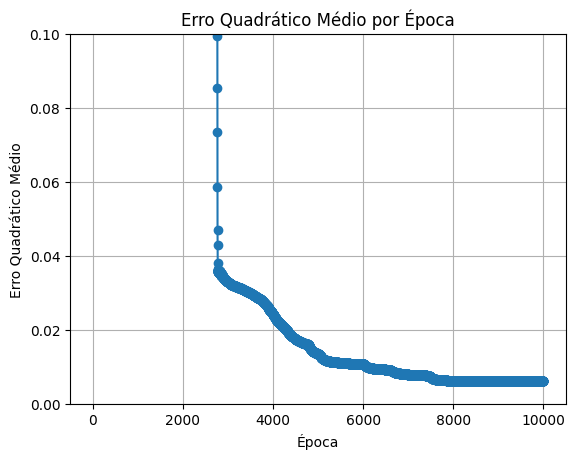

Porcentagem de acertos:  72.55639097744361


In [31]:
def teste_holdout(tamanho_camada_escondida, learning_rate, epocas):
    # Chama o método processo_ml para obter a MLP treinada e os dados de teste
    mlp, x_teste, y_teste = separa_samples(tamanho_camada_escondida, learning_rate, epocas)

    # Passando os dados de teste pela MLP para obter previsões
    previsoes_teste = mlp.feedforward(x_teste)

    # Recuperando os rótulos originais dos dados de teste
    rotulos_teste_originais = np.argmax(y_teste, axis=1)

    acertos = 0
    for i in range(len(previsoes_teste)):
        saida_a = np.argmax(previsoes_teste[i])
        esperado = np.argmax(y_teste[i])
        if saida_a == esperado:
            acertos += 1

    porcentagem_acertos = (acertos / len(previsoes_teste)) * 100

    print('Porcentagem de acertos: ', porcentagem_acertos)

teste_holdout(tamanho_camada_escondida, learning_rate, epocas)

#Holdout com parada antecipada

#Cross validation sem parada antecipada

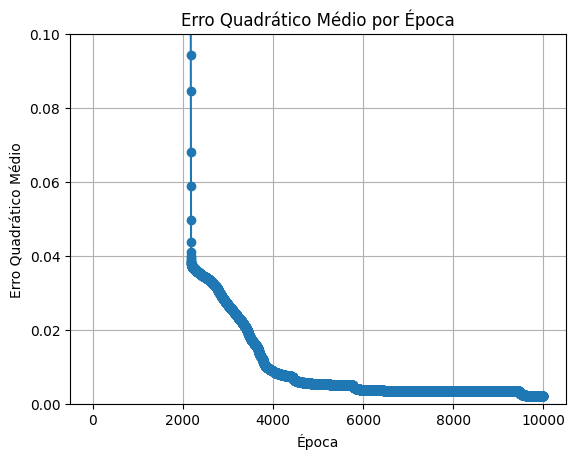

Porcentagem de acertos do fold 1: 79.69924812030075


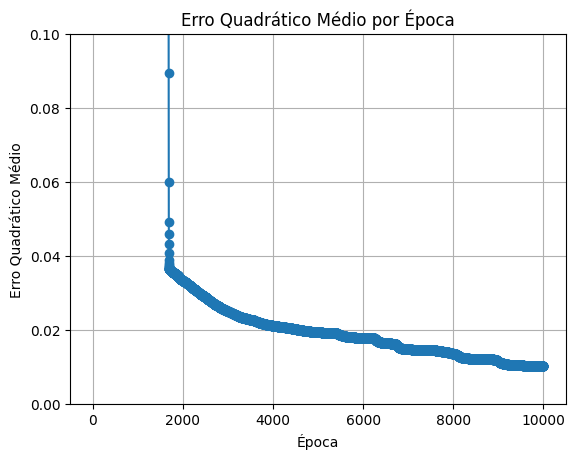

Porcentagem de acertos do fold 2: 60.37735849056604


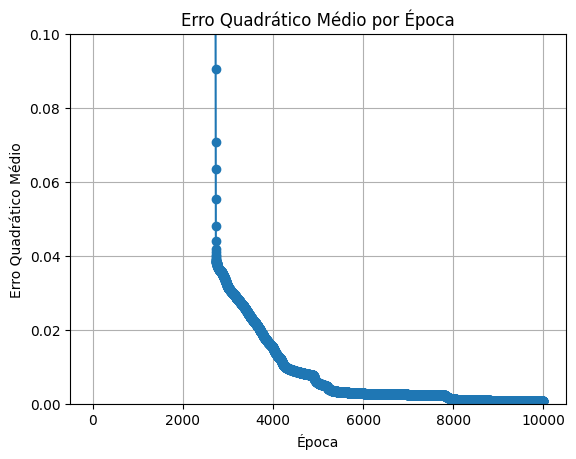

Porcentagem de acertos do fold 3: 83.39622641509435


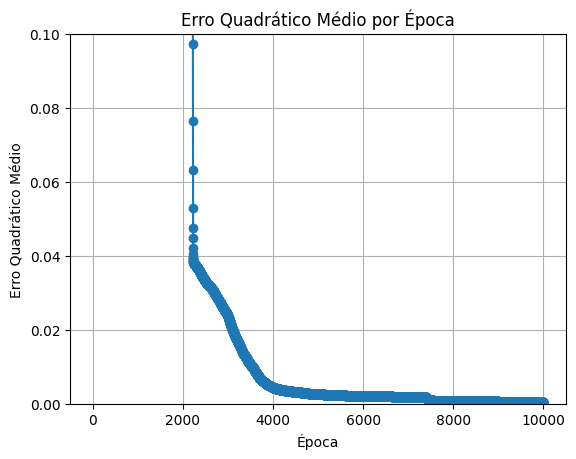

Porcentagem de acertos do fold 4: 83.39622641509435


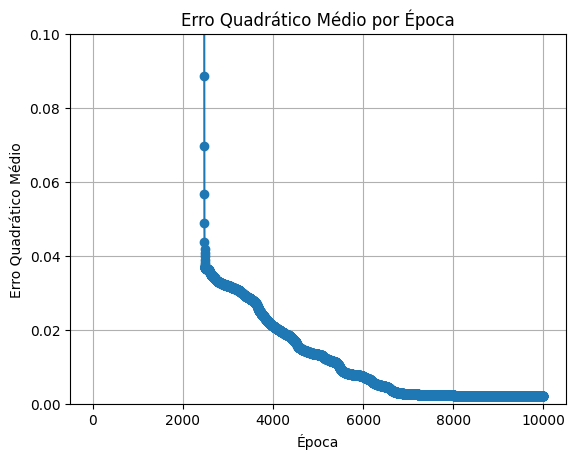

Porcentagem de acertos do fold 5: 78.11320754716982


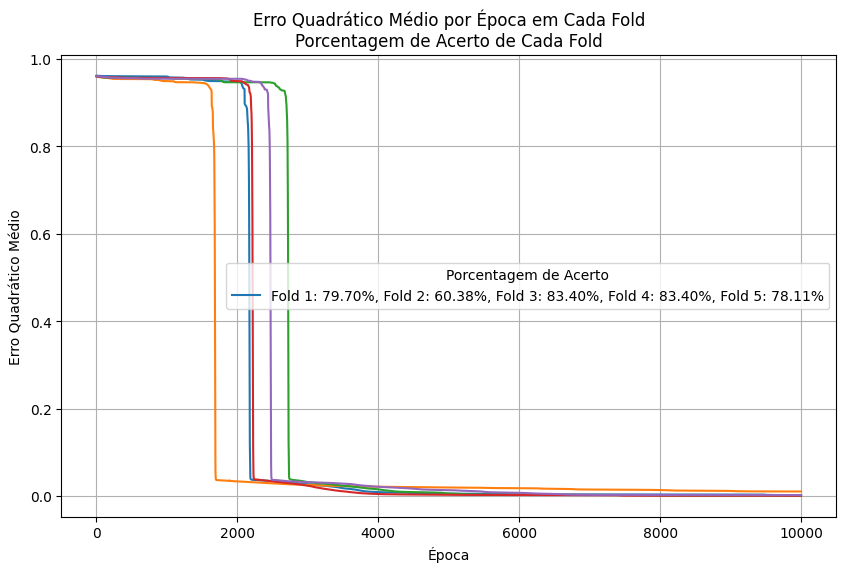


Tabela de Acurácia por Fold:
             Fold  Acurácia (%)
0               1     79.699248
1               2     60.377358
2               3     83.396226
3               4     83.396226
4               5     78.113208
5  Acurácia Final  77.00 ± 8.56


In [60]:
def cross_validation_sem_parada_antecipada(tamanho_camada_escondida, learning_rate, epocas, n_splits):
    leitura_dados = LeituraDados()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_errors = []
    all_acuracias = []

    for fold, (train_index, test_index) in enumerate(kf.split(leitura_dados.x), 1):
        x_treinamento, x_teste = leitura_dados.x[train_index], leitura_dados.x[test_index]
        y_treinamento, y_teste = leitura_dados.y[train_index], leitura_dados.y[test_index]

        mlp = MLP(leitura_dados.tamanho_entrada, tamanho_camada_escondida, leitura_dados.num_classes, learning_rate)
        errors = mlp.treinamento(x_treinamento, y_treinamento, epocas)
        all_errors.append(errors)

        previsoes_teste = mlp.feedforward(x_teste)
        rotulos_teste_originais = np.argmax(y_teste, axis=1)

        acertos = 0
        for i in range(len(previsoes_teste)):
            saida_a = np.argmax(previsoes_teste[i])
            esperado = np.argmax(y_teste[i])
            if saida_a == esperado:
                acertos += 1

        acuracia = (acertos / len(previsoes_teste)) * 100
        all_acuracias.append(acuracia)

        print(f'Porcentagem de acertos do fold {fold}: {acuracia}')

    # Plotando os gráficos de erro quadrático médio para cada fold em um único gráfico
    plt.figure(figsize=(10, 6))
    for i, errors in enumerate(all_errors):
        plt.plot(range(1, epocas+1), errors, label=f'Fold {i+1}')

    # Incluindo as porcentagens de acerto na legenda do gráfico
    acuracias_text = ', '.join([f'Fold {i+1}: {acuracia:.2f}%' for i, acuracia in enumerate(all_acuracias)])
    plt.xlabel('Época')
    plt.ylabel('Erro Quadrático Médio')
    plt.title('Erro Quadrático Médio por Época em Cada Fold\nPorcentagem de Acerto de Cada Fold')
    plt.legend(title='Porcentagem de Acerto', labels=[acuracias_text])
    plt.grid(True)
    plt.show()

    # Criando a tabela com a porcentagem de acerto em cada fold
    data = {'Fold': range(1, n_splits + 1), 'Acurácia (%)': all_acuracias}
    df = pd.DataFrame(data)

    # Calculando a acurácia final
    media_acuracia = np.mean(all_acuracias)
    desvio_padrao_acuracia = np.std(all_acuracias)
    acuracia_final = f'{media_acuracia:.2f} ± {desvio_padrao_acuracia:.2f}'

    # Adicionando a acurácia final à tabela
    df.loc[len(df)] = ['Acurácia Final', acuracia_final]

    print('\nTabela de Acurácia por Fold:')
    print(df)

cross_validation_sem_parada_antecipada(tamanho_camada_escondida, learning_rate, epocas, n_splits)

#Cross validation com parada antecipada

#Arquivos de saída

In [33]:
#Define o diretório de output

output_dir = "output_files"
#Cria diretório de output
os.makedirs(output_dir, exist_ok=True)

salva hiperparâmetros finais da arquitetura da rede neural e
hiperparâmetros de inicialização no txt

In [ ]:
def save_hyperparameters_to_file(leitura_dados, tamanho_camada_escondida, tamanho_camada_saida, learning_rate, epocas, file_path):
    with open(file_path, 'w') as arquivo:
        arquivo.write('Hiperparâmetros finais e de inicialização:\n\n')
        arquivo.write(f'Tamanho da camada de entrada: {leitura_dados.tamanho_entrada}\n')
        arquivo.write(f'Tamanho da camada escondida: {tamanho_camada_escondida}\n')
        arquivo.write(f'Tamanho da camada de saída: {tamanho_camada_saida}\n')
        arquivo.write(f'Taxa de aprendizado: {learning_rate}\n')
        arquivo.write(f'Épocas: {epocas}\n')

# Inicializa a classe de leitura de dados
leitura_dados = LeituraDados()

# Define os hiperparâmetros
tamanho_camada_entrada = leitura_dados.tamanho_entrada
tamanho_camada_saida = leitura_dados.num_classes

# Cria uma instância da classe MLP usando os atributos da classe LeituraDados
mlp = MLP(leitura_dados.tamanho_entrada, tamanho_camada_escondida, leitura_dados.num_classes, learning_rate)

# Salva os hiperparâmetros finais e de inicialização
save_hyperparameters_to_file(leitura_dados, tamanho_camada_escondida, tamanho_camada_saida, learning_rate, epocas, '/content/output_files/hiperparametros.txt')

salva pesos iniciais no txt

In [ ]:
def save_inicial_weights_to_file(weights_input_hidden, weights_hidden_output, file_path):
    with open(file_path, 'w') as arquivo:
        arquivo.write('Pesos da camada de entrada para a camada escondida\n')
        for linha in weights_input_hidden:
            for peso in linha:
                arquivo.write(str(peso) + '\n')

        arquivo.write('\nPesos da camada escondida para a camada saída\n')
        for linha in weights_hidden_output:
            for peso in linha:
                arquivo.write(str(peso) + '\n')

# Inicializa a classe de leitura de dados
leitura_dados = LeituraDados()

# Define os hiperparâmetros
tamanho_camada_entrada = leitura_dados.tamanho_entrada
tamanho_camada_saida = leitura_dados.num_classes

#Cria uma instância da classe MLP
mlp = MLP(tamanho_camada_entrada, tamanho_camada_escondida, tamanho_camada_saida, learning_rate)

#Salva os pesos da camada de entrada para a camada oculta e da camada oculta para a camada de saída no mesmo arquivo
save_inicial_weights_to_file(mlp.pesos_saindo_camada_de_entrada_para_escondida, mlp.pesos_saindo_camada_escondida_para_saida, '/content/output_files/pesosInicias.txt')

salva pesos finais no txt

In [ ]:
def save_final_weights_to_file(weights_input_hidden, weights_hidden_output, file_path):
    with open(file_path, 'w') as arquivo:
        arquivo.write('Pesos finais da camada de entrada para a camada escondida\n')
        for linha in weights_input_hidden:
            for peso in linha:
                arquivo.write(str(peso) + '\n')

        arquivo.write('\nPesos finais da camada escondida para a camada saída\n')
        for linha in weights_hidden_output:
            for peso in linha:
                arquivo.write(str(peso) + '\n')

#Cria uma instância da classe MLP
mlp = MLP(tamanho_camada_entrada, tamanho_camada_escondida, tamanho_camada_saida, learning_rate)

#Salva os pesos finais da camada de entrada para a camada oculta e da camada oculta para a camada de saída
save_final_weights_to_file(mlp.pesos_saindo_camada_de_entrada_para_escondida, mlp.pesos_saindo_camada_escondida_para_saida, '/content/output_files/pesosFinais.txt')

#Matriz de confusão

[Text(0.5, 0, 'Labels Previstos'),
 Text(0, 0.5, 'Labels Verdadeiros'),
 Text(0.5, 1.0, 'Matriz de Confusão')]

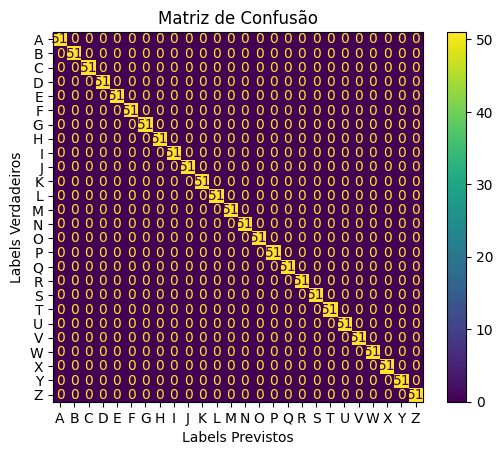

In [ ]:
#Labels verdardeiros
y_true = []
with open('/content/Y_letra.txt', 'r') as file:
    for line in file:
        y_true.append(line.strip())

#Labels previstos pelo modelo
y_pred = []
with open('/content/Y_letra.txt', 'r') as file:
    for line in file:
        y_pred.append(line.strip())

#Gera a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

#Plota matriz de confusão
cmd = ConfusionMatrixDisplay(cm, display_labels=['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
cmd.plot()
cmd.ax_.set(xlabel = 'Labels Previstos', ylabel = 'Labels Verdadeiros', title = 'Matriz de Confusão')
